# <span style='background:Yellow'> Bottom Temp & Salt difference between ECCO and WOA

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.aae61b4bf06c4bc7a30eeb77b837a592/status,


In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
import geopandas
import scipy
import xesmf as xe

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def open_ds(path, filename):    
    return xr.open_dataset(path+filename, decode_times=False)

woa_path = '/home/jovyan/chapter1/WOA/'
ecco_path = '/home/jovyan/chapter1/ECCO-budgets/'

woa0512_pt1 = open_ds(woa_path,'pt_bottom_wg_0512.nc')
woa0512_pt_error1 = open_ds(woa_path, 'pt_bottom_error_0512.nc')
woa0512_slt1 = open_ds(woa_path, 'san_bottom_wg_0512.nc')
woa0512_slt_error1 = open_ds(woa_path, 'san_bottom_error_0512.nc')

ecco_temp = open_ds(ecco_path, 'bottom_temp.nc')
ecco_std_temp = open_ds(ecco_path, 'bottom_std_temp.nc')
ecco_slt = open_ds(ecco_path, 'bottom_slt.nc')
ecco_std_slt = open_ds(ecco_path, 'bottom_std_slt.nc')

depth = open_ds(ecco_path, 'depth.nc')
surface_mask = open_ds(ecco_path, 'surface_mask.nc')
lat = open_ds(ecco_path, 'lat.nc')
lon = open_ds(ecco_path, 'lon.nc')

In [4]:
#slicing lat to be 57.5˚S so it's closer to SOSE's boundaries
woa0512_pt = woa0512_pt1.isel(lat=slice(None, -5))
woa0512_pt_error = woa0512_pt_error1.isel(lat=slice(None, -5))
woa0512_slt = woa0512_slt1.isel(lat=slice(None, -5))
woa0512_slt_error = woa0512_slt_error1.isel(lat=slice(None, -5))

# <span style='background:Pink'> <font color='Red'> Temperature </font>

### <span style='color:Brown'> Interpolating WOA (2005-2012) temp data onto ECCO's grid

In [5]:
temp = ecco_temp.THETA

In [6]:
temp

<xarray.DataArray 'THETA' (j: 60, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [ 0.280992,  0.241354,  0.247503, ..., -0.620108, -0.620631, -0.620529],
       [ 0.35721 ,  0.273651,  0.321957, ..., -0.619164, -0.619502, -0.620221],
       [ 0.376518,  0.325719,  0.300547, ..., -0.618357, -0.618776, -0.620068]],
      dtype=float32)
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 ...
    lon      (j, i) float32 ...
    lat      (j, i) float32 ...

In [7]:
regridder = xe.Regridder(woa0512_pt, ecco_temp, method='bilinear')

woa0512_pt_new_grid = regridder(woa0512_pt)
woa0512_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 60, i: 95)
Coordinates:
  * time     (time) float32 6.0
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
Data variables:
    PT       (time, j, i) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp error data onto ECCO's grid

In [8]:
regridder_0512_error = xe.Regridder(woa0512_pt_error, ecco_temp, method='bilinear')

woa0512_pt_error_new_grid = regridder(woa0512_pt_error)
woa0512_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, j: 60, i: 95)
Coordinates:
  * time      (time) float32 6.0
  * i         (i) int64 153 154 155 156 157 158 ... -117 -116 -115 -114 -113
  * j         (j) int64 30 31 32 33 34 35 36 37 38 ... 82 83 84 85 86 87 88 89
    lon       (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat       (j, i) float32 -80.07 -80.14 -80.21 ... -57.27 -57.27 -57.27
    k         (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
Data variables:
    PT_error  (time, j, i) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `ECCO - WOA` (2005-2012) </font>

In [9]:
#checking if nans
print(np.isnan(ecco_temp.sum()))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    THETA    bool False


In [10]:
ecco_woa0512_diff = ecco_temp.THETA - woa0512_pt_new_grid.isel(time=0).PT
ecco_woa0512_diff

<xarray.DataArray (j: 60, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.06259999, -2.79794253, -2.52053589, ..., -0.76243456,
        -0.77450976, -0.78119534],
       [-3.52002998, -3.29667744, -2.97726993, ..., -0.92007845,
        -0.94382591, -0.96156603],
       [ 0.37651792,  0.32571861,  0.30054694, ..., -0.61835676,
        -0.61877578, -0.62006807]])
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
    time     float32 6.0

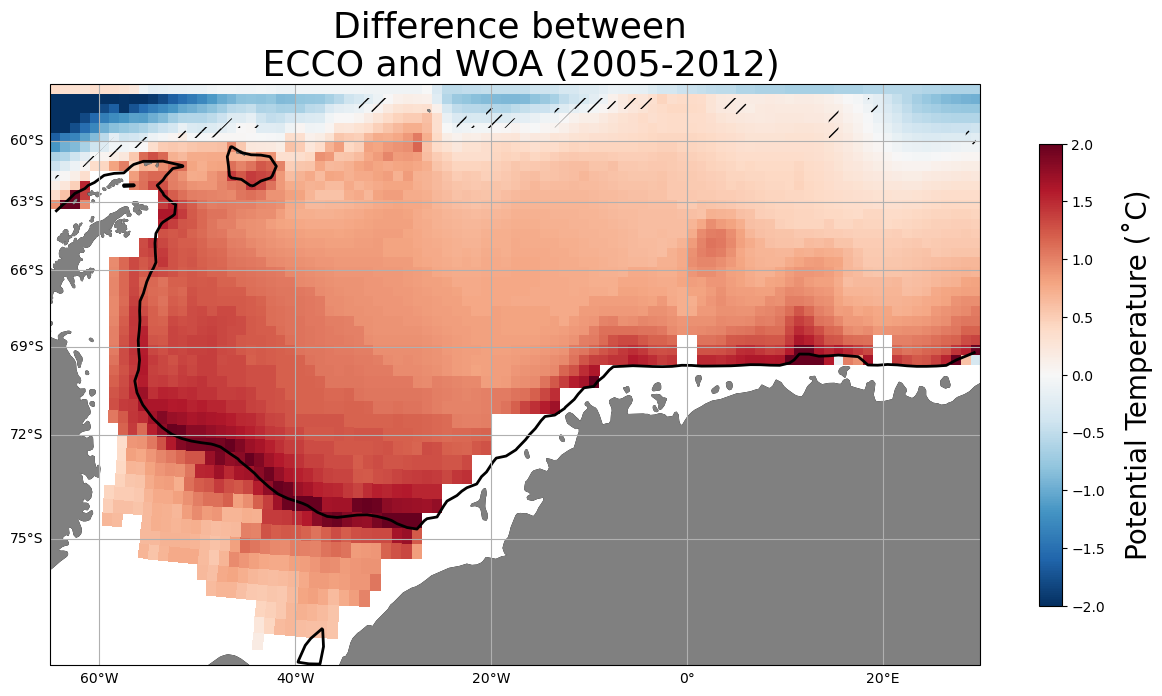

In [11]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(ecco_woa0512_diff.lon, ecco_woa0512_diff.lat, 
           depth.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(ecco_woa0512_diff.lon, 
                   ecco_woa0512_diff.lat, 
                   ecco_woa0512_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

plt.contourf(ecco_woa0512_diff.lon, 
             ecco_woa0512_diff.lat,  
             ecco_woa0512_diff.where(np.abs(ecco_woa0512_diff) < woa0512_pt_error_new_grid.PT_error[0]).where(surface_mask.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO and WOA (2005-2012)", fontsize=26)
plt.savefig('bot-temp-eccoWoa8110-1kmisobath.pdf', transparent=True);

# <span style='background:Pink'> <font color='Red'> Salinity </font>

### <span style='color:Brown'> Interpolating WOA (2005-2012) salt data onto ECCO's grid

In [14]:
regridder_slt = xe.Regridder(woa0512_slt, ecco_slt, method='bilinear')

woa0512_slt_new_grid = regridder_slt(woa0512_slt)
woa0512_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 60, i: 95)
Coordinates:
  * time     (time) float32 6.0
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
Data variables:
    s_an     (time, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2012) salt ERROR data onto ECCO's grid

In [15]:
regridder_slt_error = xe.Regridder(woa0512_slt_error.s_se.fillna(0.), ecco_slt.SALT, method='bilinear')

woa0512_slt_error_new_grid = regridder_slt_error(woa0512_slt_error)
woa0512_slt_error_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, j: 60, i: 95)
Coordinates:
  * time     (time) float32 6.0
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
Data variables:
    s_se     (time, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `ECCO - WOA` (2005-2012) </font>

In [16]:
#checking if nans
print(np.isnan(ecco_slt.sum()))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    SALT     bool False


In [17]:
ecco_woa0512_slt_diff = ecco_slt.SALT - woa0512_slt_new_grid.isel(time=0).s_an
ecco_woa0512_slt_diff

<xarray.DataArray (j: 60, i: 95)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-4.6463013e-03, -8.9645386e-04,  2.0408630e-03, ...,
         2.4955750e-02,  2.4467468e-02,  2.3887634e-02],
       [-3.7651062e-03,  6.4468384e-04,  5.8937073e-03, ...,
         2.4375916e-02,  2.3715973e-02,  2.3231506e-02],
       [ 3.4708767e+01,  3.4707294e+01,  3.4706715e+01, ...,
         3.4674526e+01,  3.4673935e+01,  3.4673420e+01]], dtype=float32)
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 47 47 48 48 48 48
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -57.27 -57.27 -57.27
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    time     float32 6.0

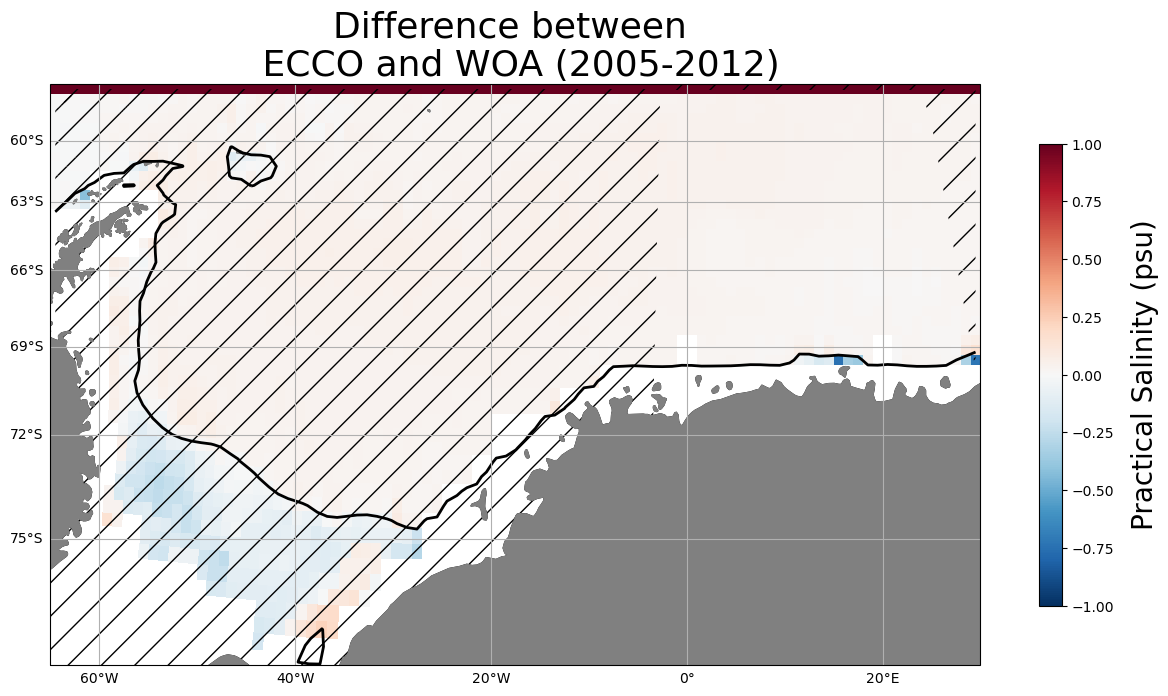

In [18]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(ecco_woa0512_slt_diff.lon, ecco_woa0512_slt_diff.lat, 
           depth.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(ecco_woa0512_slt_diff.lon, 
                   ecco_woa0512_slt_diff.lat, 
                   ecco_woa0512_slt_diff.where(surface_mask.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

plt.contourf(ecco_woa0512_slt_diff.lon, 
             ecco_woa0512_slt_diff.lat, 
             ecco_woa0512_slt_diff.where(np.abs(ecco_woa0512_slt_diff) < woa0512_slt_error_new_grid.s_se[0]).where(surface_mask.hFacC).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO and WOA (2005-2012)", fontsize=26)
plt.savefig('bot-salt-eccoWoa8110-1kmisobath.pdf', transparent=True);